*Later Morning Cohort*

**Group Members:**

1. Vaishnavi Ganesh
2. Santhosh Kumar
3. Sanjhana Rangaraj
4. Sai Lakshmi
5. Rajkumar Rajavel

*Script for package imports*
***

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import string
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from itertools import combinations
from sklearn.manifold import MDS
from itertools import product
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import statsmodels.api as sm
from scipy.stats import chisquare
from scipy.optimize import minimize_scalar
import itertools
from collections import defaultdict
from sklearn.manifold import MDS
import re
from tabulate import tabulate
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Task A

*Script for scraping*
***

In [ ]:
#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

import time
import random
import csv
import logging
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd

# Function to log in to BeerAdvocate
def login_to_beer_advocate(driver, email, password):
    print("Attempting to log in...")
    login_url = "https://www.beeradvocate.com/community/login/"
    driver.get(login_url)
    driver.maximize_window()

    try:
        WebDriverWait(driver, 30).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'form#pageLogin input#ctrl_pageLogin_login'))).send_keys(email)
        driver.find_element(By.CSS_SELECTOR, 'form#pageLogin input#ctrl_pageLogin_password').send_keys(password)
        driver.find_element(By.CSS_SELECTOR, 'form#pageLogin input[type=submit]').click()
        print("Logged in successfully!")
    except TimeoutException as e:
        print("Login timeout:", str(e))

# Function to get top-rated beer links
def get_top_rated_links(driver):
    print("Fetching top-rated beer links...")
    top_beers_url = "https://www.beeradvocate.com/beer/top-rated/"
    driver.get(top_beers_url)

    link_dict = {}

    link_elements = driver.find_elements(By.CSS_SELECTOR, 'a[href^="/beer/profile/"] > b')
    for element in link_elements:
        beer_name = element.text
        beer_link = driver.execute_script("return arguments[0].parentNode.href;", element)
        link_dict[beer_name] = beer_link

    print(f"Extracted {len(link_dict)} top-rated beer links.")
    return link_dict

# Function to scrape reviews for beers
def scrape_reviews_for_beers(driver, beer_list, max_reviews_per_beer):
    top_rated_links = get_top_rated_links(driver)
    scraped_reviews = []

    with tqdm(total=len(beer_list), desc="Processing") as pbar:
        for beer_name in beer_list:
            print(f"Scraping reviews for {beer_name}...")
            beer_link = top_rated_links.get(beer_name)

            if not beer_link:
                print(f"Could not find a link for beer: {beer_name}")
                continue

            non_empty_reviews_count = 0
            page_number = 0
            previous_page_source = None

            while non_empty_reviews_count < max_reviews_per_beer:
                if page_number > 1000:
                    print(f"Reached 50 pages for {beer_name} but did not find {max_reviews_per_beer} non-empty reviews. Moving to the next beer.")
                    break

                driver.get(f"{beer_link}?view=beer&show=recent&start={page_number}#lists")
                time.sleep(random.randint(1, 3))

                current_page_source = driver.page_source

                if current_page_source == previous_page_source:
                    print(f"Reached the last available page for {beer_name}. Moving to the next beer.")
                    break

                soup = BeautifulSoup(current_page_source, 'html.parser')
                review_containers = soup.find_all('div', {'id': 'rating_fullview_container'})

                for container in review_containers:
                    try:
                        rating = None

                        rating_tag = container.find('b')
                        if rating_tag and 'Rated:' in rating_tag.previous_sibling:
                            rating = rating_tag.text
                        else:
                            score_norm = container.find('span', class_='BAscore_norm')
                            if score_norm:
                                rating = score_norm.text

                        review_div = container.find('div', style="margin:20px 0px; font-size:11pt; line-height:1.4;")
                        review = review_div.text.strip() if review_div else None

                        if review:
                            non_empty_reviews_count += 1

                            scraped_reviews.append({
                                "Beer": beer_name,
                                "Rating": rating,
                                "Review": review
                            })
                        #print(scraped_reviews)
                        if non_empty_reviews_count == max_reviews_per_beer:
                            break
                    except Exception as e:
                        print(f"Error processing review for {beer_name}: {e}")

                page_number += 20
                previous_page_source = current_page_source

            pbar.update(1)

    return scraped_reviews

# Function to get the first N beers from top-rated list
def get_first_n_beers(driver, num_beers):
    top_rated_links = get_top_rated_links(driver)
    return list(top_rated_links.keys())[:num_beers]

def main():
    driver = webdriver.Chrome(options=chrome_options)
    beer_data = []
    # Login to BeerAdvocate
    login_to_beer_advocate(driver, "sr55737", "ahaaa_2023")

    # Get a list of beers to scrape
    beer_list_to_scrape = get_first_n_beers(driver, 250)

    # Scrape reviews for beers
    scraped_reviews = scrape_reviews_for_beers(driver, beer_list_to_scrape, max_reviews_per_beer=25)

    # Close the WebDriver
    driver.quit()
    print("WebDriver closed...")

    for review in scraped_reviews:
            beer_data.append({'beer_name': beer_name, 'beer_rating': rating, 'beer_review': review})
    # Store the data in a Pandas DataFrame or perform further processing as needed
    df = pd.DataFrame(beer_data)
    df.to_csv('beer_data.csv', index=False)

    # # Save results to a CSV file
    # with open('beer_data.csv', 'w', newline='') as file:
    #     writer = csv.DictWriter(file, fieldnames=["Beer", "Rating", "Review"])
    #     writer.writeheader()
    #     writer.writerows(scraped_reviews)
    #     print("Results saved to beer_data.csv")

if __name__ == '__main__':
    main()

*Script for reading and cleaning raw data, and doing word frequency analysis*
***

In [107]:
df = pd.read_csv('beer_data.csv')
del df[df.columns[0]]
df.head()

,beer_name,beer_rating,beer_review
0,Kentucky Brunch Brand Stout,5.00,"Amazing stout, expensive but worth the price!"
1,Kentucky Brunch Brand Stout,5.00,This beer meet and exceeded all the unreal hyp...
2,Kentucky Brunch Brand Stout,5.00,Let it sit and warm to the room a little ... u...
3,Kentucky Brunch Brand Stout,4.67,"A small pour, ebony dark, no real head. Intens..."
4,Kentucky Brunch Brand Stout,5.00,"Vintage 2022, served on tap at Toppling Goliat..."


In [108]:
#Function to remove punctuations
def remove_punctuation(text):
    translator = str.maketrans(' ', ' ', string.punctuation)
    return text.translate(translator)

#Function to remove new lines
def remove_newline(text):
  text = text.replace('\n',' ')
  return text

# Function to remove extra spaces
def remove_extra_spaces(text):
    text = ' '.join(text.split())
    return text

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [109]:
from collections import Counter

df['beer_review'] = df['beer_review'].astype(str)
df['beer_review'] = df['beer_review'].str.lower()
df['beer_review'] = df['beer_review'].apply(remove_punctuation)
df['beer_review'] = df['beer_review'].apply(remove_newline)
df['beer_review'] = df['beer_review'].apply(remove_extra_spaces)

# Remove entries with empty or space in 'Comment' column and reset index
df = df[df['beer_review'].str.strip() != '']
df.reset_index(drop=True, inplace=True)

df['beer_review'] = df['beer_review'].astype(str)

# Concatenate all messages
corpus_with_stop = " ".join(df['beer_review'])

# Tokenize the text into words and calculate freq
words_ws = corpus_with_stop.split()
word_freq_ws = Counter(words_ws)

word_freq_ws=dict(word_freq_ws)
word_freq_ws=dict(sorted(word_freq_ws.items(), key=lambda item: item[1], reverse=True))

In [110]:
df['beer_review'] = df['beer_review'].apply(remove_stopwords)

# Concatenate all messages
corpus = " ".join(df['beer_review'])

# Tokenize the text into words and calculate freq
words = corpus.split()
word_freq = Counter(words)

word_freq=dict(word_freq)
word_freq=dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

print("Top 30 words from word frequency analysis:\n")
count=0
for key, value in word_freq.items():
    if count<30:
        print(f"{key}:{value}")
        count+=1
    else:
        break

Top 30 words from word frequency analysis:

beer:4024
head:3130
taste:2653
chocolate:2416
dark:2150
sweet:2041
like:1965
notes:1861
one:1801
vanilla:1795
coffee:1756
nose:1748
nice:1689
bourbon:1688
light:1656
good:1623
finish:1553
pours:1546
well:1516
aroma:1494
carbonation:1467
fruit:1435
body:1422
orange:1422
bottle:1421
overall:1408
white:1405
bit:1378
mouthfeel:1376
barrel:1374


## Task B

*Script to take 3 attributes from user*
***

In [111]:
word_list = ["aroma","bourbon","carbonation","chocolate","citrus","coffee","creamy","dark","finish","fruit","head","lacing","light","malt","mouthfeel","oak","smooth","sweet","thick","vanilla"]

# Create a table with 4 columns
table_data = [word_list[i:i+5] for i in range(0, len(word_list), 5)]

# Display the table
print("PLease choose three attributes from this table:\n")
table = tabulate(table_data, tablefmt="fancy_grid")
print(table)

PLease choose three attributes from this table:

╒════════╤═════════╤═════════════╤═══════════╤═══════════╕
│ aroma  │ bourbon │ carbonation │ chocolate │ citrus    │
├────────┼─────────┼─────────────┼───────────┼───────────┤
│ coffee │ creamy  │ dark        │ finish    │ fruit     │
├────────┼─────────┼─────────────┼───────────┼───────────┤
│ head   │ lacing  │ light       │ malt      │ mouthfeel │
├────────┼─────────┼─────────────┼───────────┼───────────┤
│ oak    │ smooth  │ sweet       │ thick     │ vanilla   │
╘════════╧═════════╧═════════════╧═══════════╧═══════════╛


In [112]:
# Get three attributes from the user
attribute1 = input("Enter attribute 1: ")
attribute2 = input("Enter attribute 2: ")
attribute3 = input("Enter attribute 3: ")
stop_words = set(stopwords.words('english'))

# Combine the three attributes into a sentence
combined_sentence = f"{attribute1} {attribute2} {attribute3}"

# Create a CountVectorizer to convert text into bag of words vectors
vectorizer = CountVectorizer()

# Fit the vectorizer to the comments in df['beer_review']
vectorizer.fit(df['beer_review'])

# Fit and transform the text data to obtain BoW vectors
X = vectorizer.transform([combined_sentence])

Enter attribute 1: dark
Enter attribute 2: vanilla
Enter attribute 3: chocolate


## Task C

*Script for cosine similarity*
***

In [113]:
# Initialize an empty list to store cosine similarity scores
cosine_similarities = []

# Loop through each comment and calculate cosine similarity
for comment in df['beer_review']:
    # Remove stopwords from the comment
    words = comment.split()  # Tokenize the comment
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_comment = ' '.join(filtered_words)
    
    # Vectorize the comment
    comment_vector = vectorizer.transform([filtered_comment])
    
    # Calculate cosine similarity between the combined sentence and the comment
    similarity = cosine_similarity(X, comment_vector)
    
    # Append the similarity score to the list
    cosine_similarities.append(similarity[0][0])

# Add the cosine similarity scores to a new column in the DataFrame
df['cosine_similarity'] = cosine_similarities

# Display the DataFrame with cosine similarities
display(df.head(5))

,beer_name,beer_rating,beer_review,cosine_similarity
0,Kentucky Brunch Brand Stout,5.00,amazing stout expensive worth price,0.000000
1,Kentucky Brunch Brand Stout,5.00,beer meet exceeded unreal hype simply amazing,0.000000
2,Kentucky Brunch Brand Stout,5.00,let sit warm room little unbelievable,0.000000
3,Kentucky Brunch Brand Stout,4.67,small pour ebony dark real head intense rich a...,0.213504
4,Kentucky Brunch Brand Stout,5.00,vintage 2022 served tap toppling goliath snuli...,0.000000


The above table gives us the cosine similarity of each review

## Task D

*Script for sentiment analysis*
***

In [114]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

newWords = {'bitter': 2.0, 'dark': 2.0, 'nuts': 2.0}
sia.lexicon.update(newWords)

# Perform sentiment analysis on each review
sentiment_scores = []

for comment in df['beer_review']:
    sentiment = sia.polarity_scores(comment)
    sentiment_scores.append(sentiment)
    
# Add the sentiment scores to a new column in the DataFrame
df['sentiment_scores'] = sentiment_scores

# Extract the compound scores (overall sentiment) from the VADER results
df['compound_sentiment'] = [score['compound'] for score in df['sentiment_scores']]

# Display the DataFrame with sentiment scores
display(df.head(5))

,beer_name,beer_rating,beer_review,cosine_similarity,sentiment_scores,compound_sentiment
0,Kentucky Brunch Brand Stout,5.00,amazing stout expensive worth price,0.000000,"{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'comp...",0.7506
1,Kentucky Brunch Brand Stout,5.00,beer meet exceeded unreal hype simply amazing,0.000000,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp...",0.5859
2,Kentucky Brunch Brand Stout,5.00,let sit warm room little unbelievable,0.000000,"{'neg': 0.0, 'neu': 0.54, 'pos': 0.46, 'compou...",0.3415
3,Kentucky Brunch Brand Stout,4.67,small pour ebony dark real head intense rich a...,0.213504,"{'neg': 0.021, 'neu': 0.627, 'pos': 0.353, 'co...",0.9873
4,Kentucky Brunch Brand Stout,5.00,vintage 2022 served tap toppling goliath snuli...,0.000000,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",0.9069


> From Vader's lexicon and the context of the scraped beer reviews, we observed a neutral default sentiment for 'dark', and negative default sentiments for 'bitter' and 'nut.' However these words are used in a positive context in the reviews as they are mostly attributes of beers. Hence we update the lexicon to keep the default values of these words as positive.

## Task E

*Script to evaluate a combined score*
***

To get an evaluation score for each beer, we start by combining the cosine similarity and the compound sentiment analysis score by multiplying both together

In [115]:
df['combined_score']=(df['cosine_similarity'] * df['compound_sentiment'])
# display(df.head(5))

In [116]:
avg_score = pd.DataFrame({'Avg. Cosine Similarity':df.groupby(['beer_name'])['cosine_similarity'].mean(),'Avg. Sentiment Score':df.groupby(['beer_name'])['compound_sentiment'].mean(),'Avg. Combined Score':df.groupby(['beer_name'])['combined_score'].mean(),'Sample':df.groupby(['beer_name'])['combined_score'].size()})
avg_score = avg_score.sort_values(by='Sample', ascending=False)
# display(round(avg_score.head(5),3))

> Since we have also had beers with very few reviews, we looked at the sample size distribution and chose a threshold (n = 20), and only consider beers that have greater than or equal to 20 reviews henceforth 

Text(0, 0.5, '# of Beers')

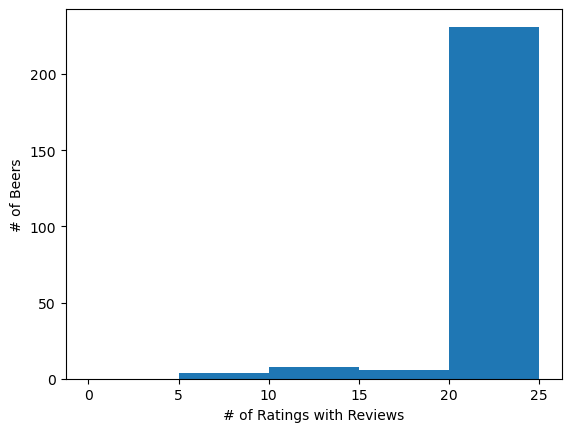

In [117]:
plt.hist(avg_score['Sample'], bins=5, range=(0, 25))
plt.xlabel('# of Ratings with Reviews')
plt.ylabel('# of Beers')

Now, to get the average evaluation score for each beer, we take an average of the combined score of the reviews for each beer as follows:

In [118]:
avg_score=avg_score[avg_score['Sample']>=20]
avg_score = avg_score.sort_values(by='Avg. Combined Score', ascending=False)
print("Based on the combined score (which is product of similarity and sentiment scores), the 3 recommended beers for the given attributes [",combined_sentence,"], are:")
display(avg_score.iloc[0:3,:-1])

Based on the combined score (which is product of similarity and sentiment scores), the 3 recommended beers for the given attributes [ dark vanilla chocolate ], are:


,Avg. Cosine Similarity,Avg. Sentiment Score,Avg. Combined Score
beer_name,,,
Fundamental Observation,0.245981,0.846352,0.227311
Modem Tones - Bourbon Barrel-Aged - Vanilla,0.242945,0.833304,0.223202
Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged,0.227130,0.860812,0.205935


## Task F

*Script to compute similarity using word vectors*
***

In [119]:
import pandas as pd
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Load spaCy's pre-trained model
nlp = spacy.load('en_core_web_md')

# Get three attributes from the user
attribute1 = input("Enter attribute 1: ")
attribute2 = input("Enter attribute 2: ")
attribute3 = input("Enter attribute 3: ")

# Combine the three attributes into a sentence
combined_sentence = f"{attribute1} {attribute2} {attribute3}"

# Create a function to calculate the average word vector of a text
def average_word_vector(text):
    doc = nlp(text)
    # Filter out stop words and punctuation
    tokens = [token for token in doc if not token.is_stop and not token.is_punct]
    if tokens:
        return sum(token.vector for token in tokens) / len(tokens)
    else:
        return nlp(" ")[0].vector  # Return a zero vector for empty sentences

# Calculate the average word vector for the combined sentence
combined_vector = average_word_vector(combined_sentence)

# Calculate cosine similarity for each beer review
cosine_similarities = []
for review in df['beer_review']:
    review_vector = average_word_vector(review)
    similarity = cosine_similarity([combined_vector], [review_vector])
    cosine_similarities.append(similarity[0][0])

# Add the cosine similarity scores to a new column in the DataFrame
df['cosine_similarity_spacy'] = cosine_similarities

Enter attribute 1: dark
Enter attribute 2: vanilla
Enter attribute 3: chocolate


In [120]:
# Display the DataFrame with cosine similarities
# display(df.head(5))

In [121]:
df['combined_score_spacy']=(df['cosine_similarity_spacy'] * df['compound_sentiment'])
# display(df.head(5))

In [122]:
avg_score_sp = pd.DataFrame({'Avg. Cosine Similarity':df.groupby(['beer_name'])['cosine_similarity_spacy'].mean(),'Avg. Sentiment Score':df.groupby(['beer_name'])['compound_sentiment'].mean(),'Avg. Combined Score':df.groupby(['beer_name'])['combined_score_spacy'].mean(),'Sample':df.groupby(['beer_name'])['combined_score_spacy'].size()})
avg_score_sp = avg_score_sp.sort_values(by='Sample', ascending=False)
#display(avg_score_sp.head(10))

The top 3 beers that we would recommend based on the scores calculated by using the spaCy package are as follows:

In [125]:
avg_score_sp=avg_score_sp[avg_score_sp['Sample']>=20]
avg_score_sp=avg_score_sp.sort_values(by='Avg. Combined Score', ascending=False)
display(avg_score_sp.iloc[0:3,:-1])

,Avg. Cosine Similarity,Avg. Sentiment Score,Avg. Combined Score
beer_name,,,
Double Shot,0.722338,0.925780,0.675164
KBS - Maple Mackinac Fudge,0.722678,0.904948,0.668232
Bourbon County Double Barrel Toasted Barrel Stout,0.687470,0.892660,0.648288


To compare the output of the bag-of-words methodology and the word-embeddings methodology, we start by comparing the top 10 recommendations we get from each methodology:

In [126]:
print("Recommended beers with Bag-of-Words-based similarity:")
display(avg_score.iloc[0:10,:-1])
print("\n\nRecommended beers with word-vectors-based similarity:")
display(avg_score_sp.iloc[0:10,:-1])

# Get the indices as sets
indices_avg_score = set(avg_score.head(10).index)
indices_avg_score_sp = set(avg_score_sp.head(10).index)

# Check for common elements
common_elements = indices_avg_score.intersection(indices_avg_score_sp)

# Display common elements
print("Common beers in top 10:")
print(common_elements)

Recommended beers with Bag-of-Words-based similarity:


,Avg. Cosine Similarity,Avg. Sentiment Score,Avg. Combined Score
beer_name,,,
Fundamental Observation,0.245981,0.846352,0.227311
Modem Tones - Bourbon Barrel-Aged - Vanilla,0.242945,0.833304,0.223202
Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged,0.227130,0.860812,0.205935
Bourbon County Double Barrel Toasted Barrel Stout,0.203376,0.892660,0.191347
Speedway Stout - Bourbon Barrel-Aged,0.204701,0.807624,0.182879
BDCS,0.210370,0.799628,0.182557
Nillerzzzzz,0.192841,0.891295,0.181493
"Somewhere, Something Incredible Is Waiting To Be Known",0.227014,0.712104,0.180373
Fundamental Forces,0.211186,0.795292,0.176708




Recommended beers with word-vectors-based similarity:


,Avg. Cosine Similarity,Avg. Sentiment Score,Avg. Combined Score
beer_name,,,
Double Shot,0.722338,0.925780,0.675164
KBS - Maple Mackinac Fudge,0.722678,0.904948,0.668232
Bourbon County Double Barrel Toasted Barrel Stout,0.687470,0.892660,0.648288
Speedway Stout - Vietnamese Coffee,0.715342,0.869644,0.638160
Double Barrel V.S.O.J.,0.680628,0.860540,0.620024
Parabajava,0.692161,0.838112,0.611954
Hold On To Sunshine,0.687755,0.863416,0.610156
Yellow Bus,0.677781,0.901632,0.608763
The Rusty Nail,0.679041,0.845672,0.608516


Common beers in top 10:
{'Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged', 'Bourbon County Double Barrel Toasted Barrel Stout'}


> Only 2 out of 10 beers recommended by each methodology are common, suggesting that the recommendation systems differ when the method of calculting similarity is different

In [130]:
count_positive_similarity = sum(1 for similarity in df['cosine_similarity'] if similarity > 0)
count_positive_similarity_spacy = sum(1 for similarity in df['cosine_similarity_spacy'] if similarity > 0)

# display(count_positive_similarity)
# display(count_positive_similarity_spacy)

> We feed the attributes of dark, chocolate, and vanilla to our 2 recommender systems - the difference between the 2 are that one uses bag-of-words based cosine similarity, while the other uses word-embedding-based cosine similarity.

> For the example attributes given, we note that out of the total of 5994 reviews, 2104 (bag-of-words based cosine similarity) and 5926 (word-embedding-based cosine similarity) reviews are counted as 'similar' to the vector 'dark-chocolate-vanilla'

> This count is much higher for word-embedding-based similarity because it counts synonyms and forms of the words (in this case, dark-chocolate-vanilla) when they are present in reviews of the beer

> While this may seem smart, in this context of building a recommender system, it is not a favorable property. As an example of this, when displaying the top 10 recommendations for 'dark-chocolate-vanilla' we see the beer called 'Yellow Bus' pops up in the list recommended using word-embedding-based similarity. But this is a beer noted by its juicy flavors of pineapple, grapefruit and lychee, and dark-chocolate-vanilla do not pop up in its flavor profile. The reason that this beer shows up though may be because of words very similar to dark-chocolate-vanilla

## Task G

*Script for finding the top 3 rated beers:*
***

In [88]:
df_top3_rating = pd.DataFrame({'Avg. Beer Rating (out of 5)':df.groupby(['beer_name'])['beer_rating'].mean(),'Avg. Cosine Similarity':df.groupby(['beer_name'])['cosine_similarity'].mean(),'Avg. Sentiment Score':df.groupby(['beer_name'])['compound_sentiment'].mean(),'Avg. Combined Score':df.groupby(['beer_name'])['combined_score'].mean(),'Sample':df.groupby(['beer_name'])['combined_score'].size()})

df_top3_rating = df_top3_rating.sort_values(by='Avg. Beer Rating (out of 5)', ascending=False)

df_top3_rating = df_top3_rating[df_top3_rating['Sample']>=20]

print("The top 3 rated beers (average ratings taken from the reviews scraped), are given below. The similarity, sentiment, and combined scores shown are for the previously taken attributes of dark-vanilla-chocolate.")
display(df_top3_rating.head(3))


avg_score_with_rating = df_top3_rating.sort_values(by='Avg. Combined Score', ascending=False)

print("\n\nComparing the recommendations with our original recommendations,")
display(avg_score_with_rating.head(3))

The top 3 rated beers (average ratings taken from the reviews scraped), are given below. The similarity, sentiment, and combined scores shown are for the previously taken attributes of dark-vanilla-chocolate.


,Avg. Beer Rating (out of 5),Avg. Cosine Similarity,Avg. Sentiment Score,Avg. Combined Score,Sample
beer_name,,,,,
Vanilla Bean Assassin,4.8344,0.188613,0.713432,0.163479,25
Oude Fermier,4.7840,0.009512,0.873392,0.008800,25
Double Barrel V.S.O.J.,4.7292,0.137831,0.859480,0.127661,25




Comparing the recommendations with our original recommendations,


,Avg. Beer Rating (out of 5),Avg. Cosine Similarity,Avg. Sentiment Score,Avg. Combined Score,Sample
beer_name,,,,,
Fundamental Observation,4.521200,0.245981,0.846340,0.227308,25
Modem Tones - Bourbon Barrel-Aged - Vanilla,4.649583,0.242945,0.833304,0.223202,24
Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged,4.374000,0.227130,0.860812,0.205935,25


> We can see that the top-3 rated beers would not be ideal recommendations for the example attributes chosen (dark-vanilla-chocolate), because the combined scores are much lesser than the scores derived from that of the ideal recommendations (which are in the range of 0.20 to 0.22).

> In general, the top-3 rated beers would have been rated highly only based on their specific attributes. Practically these attributes can only be limited. So the idea of recommending these 3 beers for any user-given set of attributes would defeat the purpose of giving customized recommendations.

## Task H

*Script choosing top 4 frequent attributes, 10 random beers, and finding similar beers using lift values*
***

From the word frequency analysis done in the above steps, we choose the top 4 attributes as 'dark', 'vanilla', 'chocolate' and 'sweet'

In addition to this we choose 10 beers randomnly

In [98]:
attributes = ['head', 'dark', 'chocolate', 'sweet']
beer_10=['Blessed', 'Clover', 'Anabasis', 'Julius', 'Assassin', 'Abner', 'Aaron', 'KBS', 'Headroom', 'Green']
attr_beer = attributes + beer_10
# display(attr_beer)

In [99]:
# Open and read the CSV file

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
total_comments = 0
comments = []  # Store tokenized comments

with open('beer_data.csv', mode='r', newline='', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip the header row if it exists
    next(csv_reader, None)

    # Iterate through the rows and tokenize the comments
    for row in csv_reader:
        comment = row[3]  # Assuming the comments are in the third column
        total_comments += 1

        # Tokenize the comment text, splitting on spaces and removing commas
        tokens = comment.split()
        filtered_tokens = [token.replace(',', '') for token in tokens if token.lower() not in stop_words]

        comments.append(filtered_tokens)  # Store the tokenized comment

# print(comments)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
# List of attributes to check
attributes = ['head', 'dark', 'chocolate', 'sweet']

# Create an empty DataFrame with columns for attributes
df_a = pd.DataFrame(columns=attributes)

# Iterate through each comment
for comment in comments:
    # Create a dictionary to store attribute presence (1 or 0) in the current comment
    attribute_presence = {}
    
    # Check if each attribute is present in the comment
    for attribute in attributes:
        attribute_presence[attribute] = 1 if attribute in comment else 0
    
    # Append the attribute presence dictionary as a new row in the DataFrame
    df_a = df_a.append(attribute_presence, ignore_index=True)

# Fill missing values (NaN) with 0, in case some attributes are not present in any comments
df_a = df_a.fillna(0)

In [101]:
beer_sample=pd.DataFrame({'sample':df.groupby(['beer_name'])['combined_score'].size()}).reset_index()
#display(beer_sample)
beer_comment_info = df.join(df_a)
#display(beer_10)
beer_comment_info=beer_comment_info[beer_comment_info['beer_name'].isin(beer_10)]
# display(beer_comment_info)

In [102]:
attribute_occurences = beer_comment_info[attributes].sum()
#display(attribute_occurences)
column_names = ['combined_score']+attributes
num_rows=beer_comment_info.shape[0]
#print(num_rows)

# Initialize an empty dictionary to store the results
result_dict = {}
#display(result_dict)

# Perform groupby operations for each column
result_dict['sample'] = beer_comment_info.groupby(['beer_name']).size()
for column_name in column_names:
    result_dict[f'{column_name}'] = beer_comment_info.groupby(['beer_name'])[column_name].sum()

# Create the 'beer_info' DataFrame
beer_info = pd.DataFrame(result_dict)

# Reset the index
beer_info.reset_index(inplace=True)

# Print the result
# display(beer_info)

In [103]:
for i in range(len(beer_info)):
    beer_info['attribute1_lift']=(beer_info[attributes[0]]*num_rows)/(beer_info.at[i,'sample']*attribute_occurences[0])
    beer_info['attribute2_lift']=(beer_info[attributes[1]]*num_rows)/(beer_info.at[i,'sample']*attribute_occurences[1])
    beer_info['attribute3_lift']=(beer_info[attributes[2]]*num_rows)/(beer_info.at[i,'sample']*attribute_occurences[2])
    beer_info['attribute4_lift']=(beer_info[attributes[3]]*num_rows)/(beer_info.at[i,'sample']*attribute_occurences[3])

beer_info_cln = beer_info.drop(columns = ['combined_score','sample'])
display(beer_info_cln)

,beer_name,head,dark,chocolate,sweet,attribute1_lift,attribute2_lift,attribute3_lift,attribute4_lift
0,Aaron,7,14,2,6,0.909091,2.916667,0.50,1.363636
1,Abner,9,0,0,3,1.168831,0.000000,0.00,0.681818
2,Anabasis,5,9,7,6,0.649351,1.875000,1.75,1.363636
3,Assassin,7,8,7,4,0.909091,1.666667,1.75,0.909091
4,Blessed,5,7,10,8,0.649351,1.458333,2.50,1.818182
5,Clover,13,0,0,3,1.688312,0.000000,0.00,0.681818
6,Green,11,2,0,2,1.428571,0.416667,0.00,0.454545
7,Headroom,5,0,0,2,0.649351,0.000000,0.00,0.454545
8,Julius,8,2,0,7,1.038961,0.416667,0.00,1.590909
9,KBS,7,6,14,3,0.909091,1.250000,3.50,0.681818


In [104]:
# Create an empty DataFrame to store the top 3 similar rows for each row
similar_rows_df = pd.DataFrame(columns=['beer_name', 'most_similar_beer'])

# Iterate through each row
for index, row in beer_info.iterrows():
    # Calculate absolute differences between the current row and all other rows
    beer_info['difference'] = beer_info.apply(lambda r: abs(row['attribute1_lift'] - r['attribute1_lift']) +
                                          abs(row['attribute2_lift'] - r['attribute2_lift']) +
                                          abs(row['attribute3_lift'] - r['attribute3_lift']) +
                                          abs(row['attribute4_lift'] - r['attribute4_lift']), axis=1)
    
    # Sort by differences and select the top 3 most similar rows (excluding the current row)
    top_similar_rows = beer_info.sort_values(by='difference').iloc[1]
    
    # Store the top 3 similar rows in the similar_rows_df
    similar_rows_df = similar_rows_df.append({'beer_name': row['beer_name'], 'most_similar_beer': top_similar_rows['beer_name']}, ignore_index=True)

> The methodology for choosing most similar beer (for a chosen beer) was to choose the beer with the smallest score. Here we define that 'score' as the sum of the differences between the lifts across attributes, i.e., the beers with the closest lift values for the given attributes

Choosing Anabasis, we see that Assassin was the most similar beer in terms of the attributes that we gave, i.e. 'head, 'dark', 'chocolate', 'sweet'.

In [105]:
similar_rows_df[similar_rows_df['beer_name']=="Anabasis"]

,beer_name,most_similar_beer
2,Anabasis,Assassin
